# A. Errata - previous (submitted) implementation
- I passed in ordinal features Qualifications and Membership as numeric features instead of categorical. The mapping to numerics should have been with with OrdinalEncoder in the pipeline, rather than during clean steps. Some models had a score difference of 0.5-1%.
- `roc_auc_score` wrongly calculated using y_pred instead of y_pred_proba values. Surprisingly, errors weren't too bad, in the order of 0-2%.
  
- Evaluation:
  - Using oversampled data, `GridsearchCV` scoring should have been done on `roc_auc`, to get model with highest predictive power. 
    - On a real-world project, further rounds of trials could be done, to see if using F-scores (imbalanced data) vs ROC AUC (resampled data) gives any competitive advantage. In this case, I'm sticking with oversampling and using `roc_auc` as the metric.
  - Test scores should also have been computed on oversampled data. 
    - I did not notice that GridSearchCV's implementation is such that it omits the oversample step in the pipeline when calling `.predict`.
    - By ensuring both train and test sets are oversampled, the `roc_auc` scores between val and test sets are much closer, and not overfitting as I had previously interpreted. Thus the previous attempts of then regularizing/pruning the models further were counterintuitive. Thus now we can tune for highest `roc_auc`. As well as get comparative figures when testing on real world imbalanced data.
  - Upon finding models with highest val and test `roc_aucs`, do `.predict_proba`s, get classifications manually based on different proba thresholds, and plot precision, recall, F1, F2 metrics against different threshold values. Setting threshold manually, we can tune for precision-recall as needed, from the most predictive models.
  - Also should have used `.cv_results_` scores rather than rescoring using entire train/val data.

# B. Further implementation
- Implementing `HyperOptSearch` from RayTune, the algorithm was more efficient and found more predictive models. Reviewing of multiple rounds of trials/hparams also more easily done with Tensorboard.

- Applied PCA, t-SNE, feature_importances_ for tree based classifiers, to get further insights on signal-to-noise ratio in data, and review informative features. If current model is not viable, this step informs us what other data we need to get in the future for a better model.

-----------

# 1.0 New MLP Implementation using RayTune/HyperOptSearch
**Key Features**
- uses oversampled data, and `roc_auc` for scoring, to search for models with best predictive power.
- once oversampled val and test scores compared to check for overfitting, we also score on imbalanced data used to check for real world performance, for some algos, there is 1-2% performance decrease on the imbalanced set.
- manually tune precision-recall using probability thresholds (use `predict_proba`). Currently, I've selected all models to arbitrarily aim for a recall of around 0.80.

**Steps**
- We begin with a wider search space of params more than we did in `GridSearchCV`. Running 150 trials each, this algorithm is more efficient in finding the best params.
- Review metrics in Tensorboard and iterate as needed.
- Decide on a suitable probability threshold to use, and retrain final model.


**INIT DATA, RAY TUNE, SEARCH ALGOS, HELPER FUNCTIONS**

In [1]:
##### GLOBAL EXPERIMENT PARAMS

TEST_SIZE = 0.2    # define holdout set size
RANDOM_STATE = 4   # random state for train_test_split & indiv models
CV = 5             # gridsearch cv folds
SCORER = 'roc_auc' # eval metric
VERBOSE = 1        # verbosity of alerts
N_TRIALS = 150     # number of trials to conduct during search
LOCAL_DIR = "./results/attrition2"

In [3]:
##### INIT RAY
ray.shutdown()
ray.init(num_cpus=20, num_gpus=0, ignore_reinit_error=True)

2022-11-15 12:09:06,948	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.7
Ray version:,2.0.1
Dashboard:,http://127.0.0.1:8265


In [4]:
##### OVERALL RAY TUNE OBJECTIVES AND TRAINABLES

#### OVERALL SEARCH ALGORITHM, WE WILL USE HYPEROPT FOR ALL MODELS
hyperopt = HyperOptSearch(
    # space=searchspace, # our defined searchspace is inexhaustive, so pass it into Tuner rather than into search_alg here
    metric="mean_test_imb_auc",
    # metric="mean_val_os_auc",
    mode="max",
    points_to_evaluate=None,
    n_initial_points=20,
    random_state_seed=RANDOM_STATE,
    gamma=0.25,
)

### ALL OTHER MODELS WILL USE THE OTHER TRAINABLE BELOW THAT TAKES IN ONE-HOT ENCODED CAT FEATURES, WHEREAS
### HISTGBM USES THIS TRAINABLE, BECAUSE HISTGBM HAS NATIVE CATEGORICAL SUPPORT, BY FEEDING IN CATEGORICAL FEATURES AS ORDINALLY ENCODED.
def trainable_histgbm(config):
    
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
    
    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    val_os_auc_scores = []
    test_os_auc_scores = []
    test_imb_auc_scores = []
    
    for train_ind, val_ind in splitter.split(X_train_os,y_train_os):
        
        clf.set_params(**config)
        clf.fit(X_train_os[train_ind, :], y_train_os[train_ind])

        y_pred_os = clf.predict(X_train_os[val_ind, :])
        y_testpred_os = clf.predict(X_test_os)
        y_testpred_imb = clf.predict(X_test)
        
        val_os_auc_scores.append(  roc_auc_score(y_train_os[val_ind], y_score=clf.predict_proba(X_train_os[val_ind])[:, 1] ))
        test_os_auc_scores.append( roc_auc_score(y_test_os,           y_score=clf.predict_proba(X_test_os)[:, 1]           ))
        test_imb_auc_scores.append(roc_auc_score(y_test,              y_score=clf.predict_proba(X_test)[:, 1]              ))
    
    ### REPORT SCORES
    session.report({
        'mean_val_os_auc' : np.array(val_os_auc_scores).mean(),
        'std_val_os_auc'  : np.array(val_os_auc_scores).std(),
        'mean_test_os_auc' : np.array(test_os_auc_scores).mean(),
        'mean_test_imb_auc' : np.array(test_imb_auc_scores).mean(),
    })


def trainable(config):
    
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()
    
    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    val_os_auc_scores = []
    test_os_auc_scores = []
    test_imb_auc_scores = []
    
    for train_ind, val_ind in splitter.split(X_train_os,y_train_os):
        
        clf.set_params(**config)
        clf.fit(X_train_os[train_ind, :], y_train_os[train_ind])

        y_pred_os = clf.predict(X_train_os[val_ind, :])
        y_testpred_os = clf.predict(X_test_os)
        y_testpred_imb = clf.predict(X_test)
        
        val_os_auc_scores.append(  roc_auc_score(y_train_os[val_ind], y_score=clf.predict_proba(X_train_os[val_ind])[:, 1] ))
        test_os_auc_scores.append( roc_auc_score(y_test_os,           y_score=clf.predict_proba(X_test_os)[:, 1]           ))
        test_imb_auc_scores.append(roc_auc_score(y_test,              y_score=clf.predict_proba(X_test)[:, 1]              ))
    
    ### REPORT SCORES
    session.report({
        'mean_val_os_auc' : np.array(val_os_auc_scores).mean(),
        'std_val_os_auc'  : np.array(val_os_auc_scores).std(),
        'mean_test_os_auc' : np.array(test_os_auc_scores).mean(),
        'mean_test_imb_auc' : np.array(test_imb_auc_scores).mean(),
    })

**Above, I defined the search objective to maximise for test AUC on imbalanced data. Not sure if this is at all a correct procedure, or if it's wrongful and some form of test set leakage.**


**Maximising on val AUC scores, over 150 trials, we got:** (For the first model, HistGBM)
```python
     mean_val_os_auc : 0.7847     # mean cross val AUC on oversampled set
      std_val_os_auc : 0.0131
    mean_test_os_auc : 0.6294
   mean_test_imb_auc : 0.6349     # mean test AUC on imbalanced set
```
***Whereas maximising on test AUC scores, over 150 trials, we got:***
```python
     mean_val_os_auc : 0.7562
      std_val_os_auc : 0.0240
    mean_test_os_auc : 0.6482
   mean_test_imb_auc : 0.6485
```
**which seems to be a less overfit model.**

**(Further reading required on this. Otherwise, we can just maximise for `mean_val_os_auc`, simply select the best test score from the list of top n trials.)**

**(Side note, hyperparams could be reviewed further in Tensorboard, to see if better combinations can be found to reduce variance, as noting the std of 0.02 here is a bit of a concern.)**

### 1.1 HistGradientBoostingClassifier
**Tuned Model Test Set Metrics:**
accuracy|f1|f2|precision|recall|auc
-|-|-|-|-|-
0.5908|0.4067|0.5843|0.2699|0.8243|0.7472

In [17]:
##### RUN HYPEROPTSEARCH - HISTOGRAM GRADIENT BOOSTING CLASSIFIER


# NOT IN USE - HYPEROPT CAN RECEIVE CURRENT BEST_PARAMS FROM PREV TRIALS AS PRIORI
# searchspace_currbest = {                                           
#     'clf__learning_rate'     : 0.15,
#     'clf__max_leaf_nodes'    : 3,
#     'clf__min_samples_leaf'  : 160,
#     'clf__max_depth'         : 6,
#     'clf__l2_regularization' : 5,
#     'clf__max_iter'          : 400,
# }


### DEF SEARCH SPACE
searchspace_histgbm = { 
    'clf__learning_rate'     : tune.loguniform(0.001, 0.8),
    'clf__max_leaf_nodes'    : tune.randint(2,20),
    'clf__min_samples_leaf'  : tune.randint(50,500),
    'clf__max_depth'         : tune.randint(2,15),
    'clf__l2_regularization' : tune.loguniform(0.001, 1000),
    'clf__max_iter'          : tune.choice([800]),
}

# only needed to init for HistGBM to inform model of which are the cat columns
dataset = Dataset(TEST_SIZE, RANDOM_STATE)


### DEF MODEL
clf = Pipeline(steps=[
            ('clf', HistGradientBoostingClassifier(
                        categorical_features=dataset.tfm.cat_feature_mask, 
                        random_state=RANDOM_STATE))])

### DEF AND RUN TUNER
tuner = tune.Tuner(
    trainable=trainable_histgbm,
    param_space=searchspace_histgbm,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyperopt,
    ),
    run_config=RunConfig(
        name="hgb",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
        # sync_config=tune.SyncConfig(syncer=None  # Disable syncing )
    ),

)

results = tuner.fit()

2022-11-15 09:39:42,220	WARNING util.py:244 -- The `start_trial` operation took 0.626 s, which may be a performance bottleneck.
2022-11-15 09:40:04,982	WARNING util.py:244 -- The `start_trial` operation took 1.158 s, which may be a performance bottleneck.
2022-11-15 09:40:11,534	WARNING util.py:244 -- The `start_trial` operation took 0.714 s, which may be a performance bottleneck.
2022-11-15 09:40:13,099	WARNING util.py:244 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.
2022-11-15 09:40:13,982	WARNING util.py:244 -- The `start_trial` operation took 0.580 s, which may be a performance bottleneck.
2022-11-15 09:40:22,287	WARNING util.py:244 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.
2022-11-15 09:40:23,751	WARNING util.py:244 -- The `start_trial` operation took 0.518 s, which may be a performance bottleneck.
2022-11-15 09:40:34,517	INFO tune.py:758 -- Total run time: 57.98 seconds (57.71 seconds for the tuning 

**We review trial metrics below, or we can use `tensorboard --logdir {LOCAL_DIR}` and see scatterplots to see effect of hyperparams on model performance if further tweaking desired.**

In [18]:
### SHOW TOP 10 TRIALS
best_config_hgb = trial_results(results)

,mean_val_os_auc,std_val_os_auc,mean_test_os_auc,mean_test_imb_auc,config/clf__l2_regularization,config/clf__learning_rate,config/clf__max_depth,config/clf__max_iter,config/clf__max_leaf_nodes,config/clf__min_samples_leaf
111,0.8107,0.0241,0.7293,0.7234,55.4058,0.0184,4,800,8,50
134,0.9087,0.0229,0.7261,0.7183,12.9181,0.0280,6,800,14,51
62,0.8084,0.0202,0.7260,0.7168,0.5430,0.0054,5,800,8,52
103,0.7798,0.0216,0.7159,0.7164,30.5263,0.0084,4,800,9,107
149,0.7884,0.0215,0.7164,0.7150,16.4948,0.0104,4,800,7,98
...,...,...,...,...,...,...,...,...,...,...
58,0.6832,0.0203,0.6608,0.6577,221.8865,0.0274,6,800,2,211
105,0.6741,0.0225,0.6616,0.6530,182.4235,0.0064,3,800,11,398
38,0.7012,0.0255,0.6644,0.6528,168.0441,0.0034,14,800,15,156
90,0.6865,0.0176,0.6595,0.6521,0.6506,0.0023,4,800,13,353


BEST METRICS, BEST PARAMS
-------------------------

     mean_val_os_auc : 0.8107
      std_val_os_auc : 0.0241
    mean_test_os_auc : 0.7293
   mean_test_imb_auc : 0.7234


**Now we can move on to tuning the probability thresholds:**

In [5]:
"""
SAVE BEST PARAMS FROM PRIOR RUNS
"""
best_config_hgb = {
    'clf__learning_rate': 0.01836465087532626,
    'clf__max_leaf_nodes': 8,
    'clf__min_samples_leaf': 50,
    'clf__max_depth': 4,
    'clf__l2_regularization': 55.405754943620785,
    'clf__max_iter': 800}


# best_config_hgb

In [8]:
##### REBUILD MODEL FROM BEST CONFIG
dataset = Dataset(TEST_SIZE, RANDOM_STATE)
dataset.get_ordinal_imbalanced()

histgbm = Pipeline(steps=[
    ('clf', HistGradientBoostingClassifier(categorical_features=dataset.tfm.cat_feature_mask, random_state=RANDOM_STATE))])
histgbm.set_params(**best_config_hgb)

refit_model(clf=histgbm, ordinal=True, test_size=TEST_SIZE, random_state=RANDOM_STATE)

train_os_auc  test_os_auc  test_imb_auc 
      0.8727       0.7452        0.7472


**Setting threshold at 0.43, we get the following model metrics on the test set**

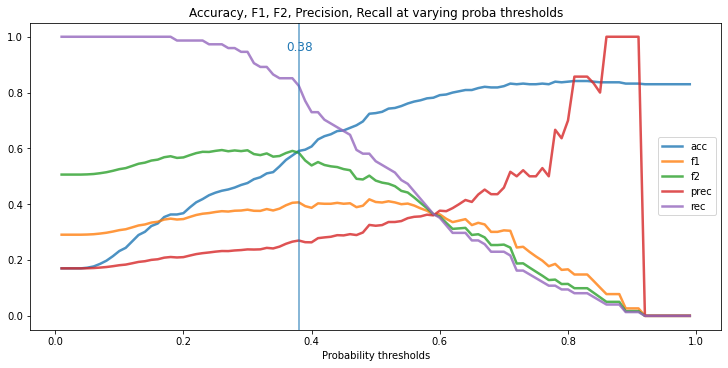

,threshold,accuracy,f1,f2,precision,recall
37,0.3800,0.5908,0.4067,0.5843,0.2699,0.8243


In [12]:
### ACCURACY, PRECISION, RECALL, F1, F2 CURVES ACROSS PROBABILITY THRESHOLDS
ordinal=True

dataset = Dataset(TEST_SIZE, RANDOM_STATE)
if (ordinal):
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
else:
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()


proba_table = tune_for_recall(histgbm, X_test, y_test, 0.38)
proba_table[(proba_table['threshold']>0.37)&(proba_table['threshold']<0.39)]

---------

### 1.2 SVC
**Tuned Model Test Set Metrics:**
accuracy|f1|f2|precision|recall|auc
-|-|-|-|-|-
0.5218|0.3620|0.5383|0.2341|0.7973|0.6614

In [5]:
##### RUN HYPEROPTSEARCH - SUPPORT VECTOR MACHINES

searchspace_svc = { 
    'clf__kernel'    : tune.choice(['rbf', 'linear', 'poly']),
    'clf__C'         : tune.loguniform(1e-4,1e-2,),
    'clf__gamma'     : tune.loguniform(1e-4,1e1),
}

clf = Pipeline(steps=[
            ('clf', SVC(probability=True, random_state=RANDOM_STATE))
            ])

### DEFINE AND RUN TUNER
tuner_svc = tune.Tuner(
    trainable=trainable,
    param_space=searchspace_svc,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyperopt,
    ),
    run_config=RunConfig(
        name="svc_os",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
        # sync_config=tune.SyncConfig(syncer=None  # Disable syncing )
    )
    
)
results_svc = tuner_svc.fit()

2022-11-15 10:19:11,874	INFO tune.py:758 -- Total run time: 139.62 seconds (138.90 seconds for the tuning loop).


In [6]:
### SHOW TOP 10 TRIALS
best_config_svc = trial_results(results_svc)

,mean_val_os_auc,std_val_os_auc,mean_test_os_auc,mean_test_imb_auc,config/clf__C,config/clf__gamma,config/clf__kernel
114,0.6355,0.0208,0.6818,0.6734,0.0091,0.0009,linear
136,0.6356,0.0211,0.6818,0.6733,0.0091,0.0065,linear
97,0.6357,0.0210,0.6815,0.6730,0.0093,0.0002,linear
145,0.6350,0.0209,0.6813,0.6729,0.0089,0.0001,linear
69,0.6358,0.0209,0.6813,0.6729,0.0093,0.0099,linear
...,...,...,...,...,...,...,...
48,0.4232,0.0503,0.4194,0.4239,0.0001,0.0003,linear
104,0.4213,0.0478,0.4175,0.4225,0.0001,0.0099,linear
3,0.4271,0.0583,0.4154,0.4205,0.0047,0.0173,rbf
53,0.2690,0.1167,0.4201,0.4197,0.0008,0.3785,rbf


BEST METRICS, BEST PARAMS
-------------------------

     mean_val_os_auc : 0.6355
      std_val_os_auc : 0.0208
    mean_test_os_auc : 0.6818
   mean_test_imb_auc : 0.6734


In [7]:
"""
best_config_svc = 
{'clf__kernel': 'poly',
 'clf__C': 0.0004802537271399022,
 'clf__gamma': 1.102578151848946}
"""
best_config_svc

{'clf__kernel': 'linear',
 'clf__C': 0.009054521569110565,
 'clf__gamma': 0.0009217102726500529}

In [8]:
##### REBUILD MODEL FROM BEST CONFIG
svc = Pipeline(steps=[
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])
svc.set_params(**best_config_svc)

refit_model(svc)

train_os_auc  test_os_auc  test_imb_auc 
      0.6451       0.6774        0.6614


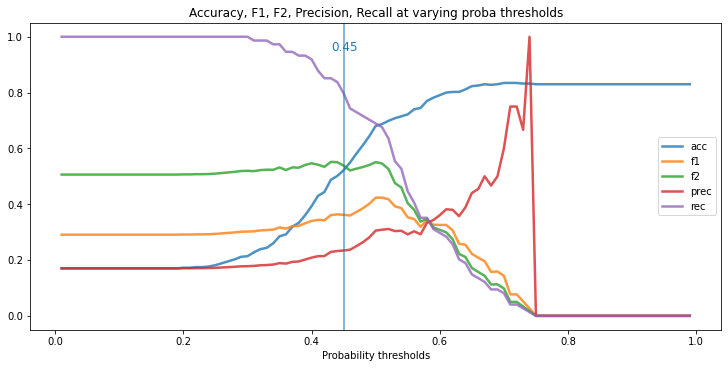

,threshold,accuracy,f1,f2,precision,recall
44,0.4500,0.5218,0.3620,0.5383,0.2341,0.7973


In [12]:
### ACCURACY, PRECISION, RECALL, F1, F2 CURVES ACROSS PROBABILITY THRESHOLDS
ordinal=False

dataset = Dataset(TEST_SIZE, RANDOM_STATE)
if (ordinal):
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
else:
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()
proba_table = tune_for_recall(svc, X_test, y_test, 0.45)
proba_table[(proba_table['threshold']>0.44)&(proba_table['threshold']<0.46)]

------------

### 2.3 Logistic Regression
**Tuned Model Test Set Metrics:**
accuracy|f1|f2|precision|recall|auc
-|-|-|-|-|-
0.5218|0.3697|0.5525|0.2383|0.8243|0.6670

In [5]:
##### RUN HYPEROPTSEARCH - LOGISTIC REGRESSION

searchspace_lrc = { 
    # 'clf__max_iter'  : tune.randint(1200,4000),
    'clf__penalty'   : tune.choice(['l1','l2']),
    'clf__solver'    : tune.choice(['saga']),
    'clf__C'         : tune.loguniform(0.0001,10000),
}

clf = Pipeline(steps=[
            ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=4000))
            ])

### DEFINE AND RUN TUNER
tuner = tune.Tuner(
    trainable=trainable,
    param_space=searchspace_lrc,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyperopt,
    ),
    run_config=RunConfig(
        name="lrc_os",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
        # sync_config=tune.SyncConfig(syncer=None  # Disable syncing )
    )
    
)
results_lrc = tuner.fit()

2022-11-15 10:21:29,588	INFO tune.py:758 -- Total run time: 34.52 seconds (33.70 seconds for the tuning loop).


In [6]:
### SHOW TOP 10 TRIALS
best_config_lrc = trial_results(results_lrc)

,mean_val_os_auc,std_val_os_auc,mean_test_os_auc,mean_test_imb_auc,config/clf__C,config/clf__penalty,config/clf__solver
141,0.6339,0.0163,0.6787,0.6747,0.0725,l1,saga
101,0.6341,0.0164,0.6786,0.6746,0.0733,l1,saga
93,0.6354,0.0163,0.6789,0.6746,0.0796,l1,saga
84,0.6370,0.0162,0.6792,0.6743,0.0902,l1,saga
99,0.6371,0.0162,0.6792,0.6743,0.0906,l1,saga
...,...,...,...,...,...,...,...
6,0.6423,0.0114,0.6740,0.6657,817.6610,l1,saga
115,0.6423,0.0114,0.6740,0.6657,853.6835,l1,saga
87,0.6423,0.0114,0.6740,0.6657,71.2668,l1,saga
23,0.6423,0.0114,0.6740,0.6657,124.9317,l2,saga


BEST METRICS, BEST PARAMS
-------------------------

     mean_val_os_auc : 0.6339
      std_val_os_auc : 0.0163
    mean_test_os_auc : 0.6787
   mean_test_imb_auc : 0.6747


In [10]:
"""
best_config_lrc = {
    'clf__penalty': 'l1', 
    'clf__solver': 'saga', 
    'clf__C': 0.07245016636509921}
"""
best_config_lrc

{'clf__penalty': 'l1', 'clf__solver': 'saga', 'clf__C': 0.07245016636509921}

In [11]:
##### REBUILD MODEL FROM BEST CONFIG
lrc = Pipeline(steps=[
    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=4000))
])
lrc.set_params(**best_config_lrc)

refit_model(lrc)

train_os_auc  test_os_auc  test_imb_auc 
      0.6461       0.6801        0.6670


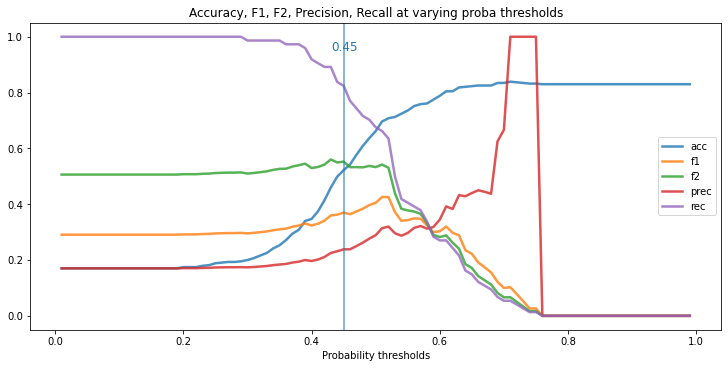

,threshold,accuracy,f1,f2,precision,recall
44,0.4500,0.5218,0.3697,0.5525,0.2383,0.8243


In [13]:
### ACCURACY, PRECISION, RECALL, F1, F2 CURVES ACROSS PROBABILITY THRESHOLDS
ordinal=False

dataset = Dataset(TEST_SIZE, RANDOM_STATE)
if (ordinal):
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
else:
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()
proba_table = tune_for_recall(lrc, X_test, y_test, 0.45)
proba_table[(proba_table['threshold']>0.44)&(proba_table['threshold']<0.46)]

### 2.4 Random Forest 
**Tuned Model Test Set Metrics:**
accuracy|f1|f2|precision|recall|auc
-|-|-|-|-|-
0.9057|0.7485|0.7922|0.6854|0.8243|0.6934



In [5]:
##### RUN HYPEROPTSEARCH - RANDOM FOREST CLASSIFIER

searchspace_rfc = { 
    'clf__max_depth'         : tune.randint(2,31),
    'clf__ccp_alpha'         : tune.loguniform(1e-5,1e5),
    'clf__bootstrap'         : tune.choice([True,False]),
    'clf__n_estimators'      : tune.randint(100,1000),
    'clf__max_features'      : tune.randint(2,31),
    'clf__min_samples_leaf'  : tune.randint(2,300),
}

clf = Pipeline(steps=[
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
            ])

### DEFINE AND RUN TUNER
tuner = tune.Tuner(
    trainable=trainable,
    param_space=searchspace_rfc,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyperopt,
    ),
    run_config=RunConfig(
        name="rfc_os",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
        # sync_config=tune.SyncConfig(syncer=None  # Disable syncing )
    )
    
)
results_rfc = tuner.fit()

2022-11-15 12:10:15,142	WARNING util.py:244 -- The `start_trial` operation took 0.973 s, which may be a performance bottleneck.
2022-11-15 12:10:20,126	WARNING util.py:244 -- The `start_trial` operation took 1.071 s, which may be a performance bottleneck.
2022-11-15 12:10:25,751	WARNING util.py:244 -- The `start_trial` operation took 0.630 s, which may be a performance bottleneck.
2022-11-15 12:10:39,971	WARNING util.py:244 -- The `start_trial` operation took 0.589 s, which may be a performance bottleneck.
2022-11-15 12:11:01,246	INFO tune.py:758 -- Total run time: 112.41 seconds (110.64 seconds for the tuning loop).


In [6]:
### SHOW TOP 10 TRIALS
best_config_rfc = trial_results(results_rfc)

,mean_val_os_auc,std_val_os_auc,mean_test_os_auc,mean_test_imb_auc,config/clf__bootstrap,config/clf__ccp_alpha,config/clf__max_depth,config/clf__max_features,config/clf__min_samples_leaf,config/clf__n_estimators
128,0.8736,0.0186,0.7277,0.7340,True,0.0000,29,19,20,849
147,0.9847,0.0069,0.7371,0.7339,True,0.0006,23,21,2,172
146,0.8607,0.0202,0.7275,0.7337,True,0.0002,24,24,23,217
145,0.8979,0.0176,0.7291,0.7335,True,0.0001,22,23,15,247
149,0.9149,0.0168,0.7289,0.7334,True,0.0003,24,25,12,314
...,...,...,...,...,...,...,...,...,...,...
6,0.5000,0.0000,0.5000,0.5000,True,6.5011,27,4,259,337
7,0.5000,0.0000,0.5000,0.5000,False,0.0394,27,6,235,661
8,0.5000,0.0000,0.5000,0.5000,True,4.9166,15,29,289,633
9,0.5000,0.0000,0.5000,0.5000,True,0.0462,26,11,198,598


BEST METRICS, BEST PARAMS
-------------------------

     mean_val_os_auc : 0.8736
      std_val_os_auc : 0.0186
    mean_test_os_auc : 0.7277
   mean_test_imb_auc : 0.7340


In [7]:
"""
best_config_rfc = 
{'clf__max_depth': 6,
 'clf__ccp_alpha': 4.146455974405224e-05,
 'clf__bootstrap': True,
 'clf__n_estimators': 518,
 'clf__max_features': 27,
 'clf__min_samples_leaf': 17}
"""

best_config_rfc

{'clf__max_depth': 29,
 'clf__ccp_alpha': 1.7960700400892016e-05,
 'clf__bootstrap': True,
 'clf__n_estimators': 849,
 'clf__max_features': 19,
 'clf__min_samples_leaf': 20}

In [8]:
##### REBUILD MODEL FROM BEST CONFIG
rfc = Pipeline(steps=[
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])
rfc.set_params(**best_config_rfc)

refit_model(rfc)

train_os_auc  test_os_auc  test_imb_auc 
      0.9610       0.6893        0.6934


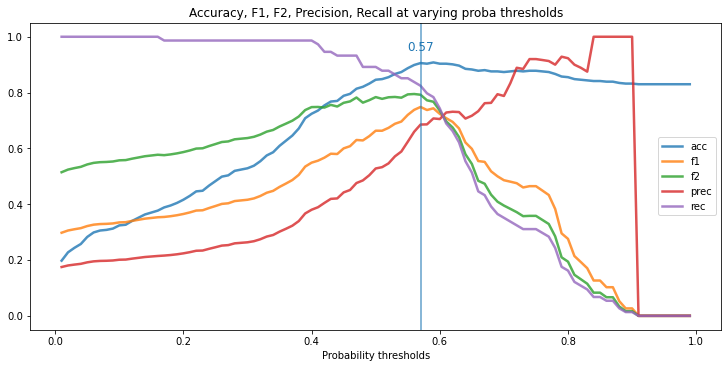

,threshold,accuracy,f1,f2,precision,recall
56,0.5700,0.9057,0.7485,0.7922,0.6854,0.8243


In [12]:
### ACCURACY, PRECISION, RECALL, F1, F2 CURVES ACROSS PROBABILITY THRESHOLDS
ordinal=False

dataset = Dataset(TEST_SIZE, RANDOM_STATE)
if (ordinal):
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
else:
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()
proba_table = tune_for_recall(rfc, X_test, y_test, 0.57)
proba_table[(proba_table['threshold']>0.56)&(proba_table['threshold']<0.58)]

### 2.5 546546546546
**Tuned Model Test Set Metrics:**
accuracy|f1|f2|precision|recall|auc
-|-|-|-|-|-



In [ ]:
##### RUN HYPEROPTSEARCH - RANDOM FOREST CLASSIFIER

searchspace_rfc = { 
    'clf__max_depth'         : tune.randint(2,31),
    'clf__ccp_alpha'         : tune.loguniform(1e-5,1e5),
    'clf__bootstrap'         : tune.choice([True,False]),
    'clf__n_estimators'      : tune.randint(100,1000),
    'clf__max_features'      : tune.randint(2,31),
    'clf__min_samples_leaf'  : tune.randint(2,300),
}

clf = Pipeline(steps=[
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
            ])

### DEFINE AND RUN TUNER
tuner = tune.Tuner(
    trainable=trainable,
    param_space=searchspace_rfc,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyperopt,
    ),
    run_config=RunConfig(
        name="rfc_os",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
        # sync_config=tune.SyncConfig(syncer=None  # Disable syncing )
    )
    
)
results_rfc = tuner.fit()

In [ ]:
### SHOW TOP 10 TRIALS
best_config_rfc = trial_results(results_rfc)

,mean_val_os_auc,std_val_os_auc,mean_test_os_auc,mean_test_imb_auc,config/clf__bootstrap,config/clf__ccp_alpha,config/clf__max_depth,config/clf__max_features,config/clf__min_samples_leaf,config/clf__n_estimators
75,0.6890,0.0300,0.6443,0.6558,True,0.0000,6,27,17,518
35,0.7757,0.0164,0.6463,0.6534,True,0.0001,17,14,26,526
145,0.7012,0.0309,0.6416,0.6529,True,0.0000,6,27,12,333
49,0.7140,0.0305,0.6385,0.6512,True,0.0000,7,21,20,994
56,0.6783,0.0240,0.6438,0.6503,True,0.0000,5,27,16,309
...,...,...,...,...,...,...,...,...,...,...
6,0.5000,0.0000,0.5000,0.5000,True,6.5011,27,4,259,337
7,0.5000,0.0000,0.5000,0.5000,False,0.0394,27,6,235,661
8,0.5000,0.0000,0.5000,0.5000,True,4.9166,15,29,289,633
9,0.5000,0.0000,0.5000,0.5000,True,0.0462,26,11,198,598


BEST METRICS, BEST PARAMS
-------------------------

     mean_val_os_auc : 0.6890
      std_val_os_auc : 0.0300
    mean_test_os_auc : 0.6443
   mean_test_imb_auc : 0.6558


In [ ]:
"""
best_config_rfc = 
{'clf__max_depth': 6,
 'clf__ccp_alpha': 4.146455974405224e-05,
 'clf__bootstrap': True,
 'clf__n_estimators': 518,
 'clf__max_features': 27,
 'clf__min_samples_leaf': 17}
"""

best_config_rfc

{'clf__max_depth': 6,
 'clf__ccp_alpha': 4.146455974405224e-05,
 'clf__bootstrap': True,
 'clf__n_estimators': 518,
 'clf__max_features': 27,
 'clf__min_samples_leaf': 17}

In [ ]:
##### REBUILD MODEL FROM BEST CONFIG
rfc = Pipeline(steps=[
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])
rfc.set_params(**best_config_rfc)

refit_model(rfc)

train_os_auc  test_os_auc  test_imb_auc 
      0.7406       0.6205        0.6390


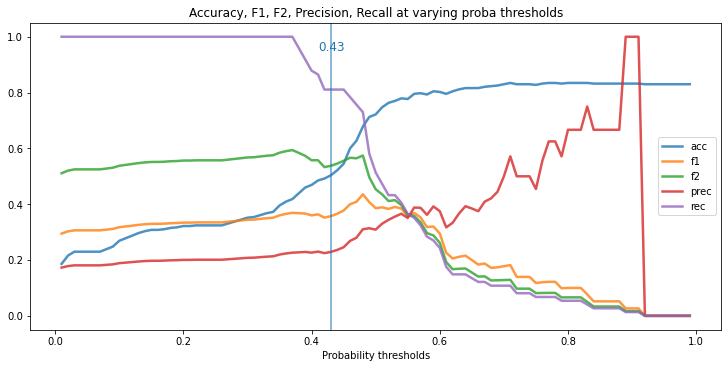

,threshold,accuracy,f1,f2,precision,recall
42,0.4300,0.5034,0.3571,0.5376,0.2290,0.8108


In [ ]:
### ACCURACY, PRECISION, RECALL, F1, F2 CURVES ACROSS PROBABILITY THRESHOLDS
ordinal=False

dataset = Dataset(TEST_SIZE, RANDOM_STATE)
if (ordinal):
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()
else:
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_onehot_oversample()
proba_table = tune_for_recall(rfc, X_test, y_test, 0.43)
proba_table[(proba_table['threshold']>0.421)&(proba_table['threshold']<0.44)]

----------------

----------------

# 2.0 Misc Feature Analysis, Review Data SNR
- Most of the nominal categorical features have low signal, other than if their Work Domain is IT.
- Data itself is quite noisy, perhaps further user surveys can be conducted to gather more informative fields. The high-signal features here could prompt us specific data of interest to capture. e.g. income, usage time, travel time, and age play a stronger factor. Data that delves further into/relates to these areas could prove to be more informative.
- Maybe not that relevant in the scope of MLP, however in terms of analytics/biz strategy, more data regarding lifestyle/social activity (e.g. why do you come to the country club, what activities/facilities do you use most/how do you rate the country club) etc might prove to be more informative.

## 2.1 PCA - cumulative explained variance

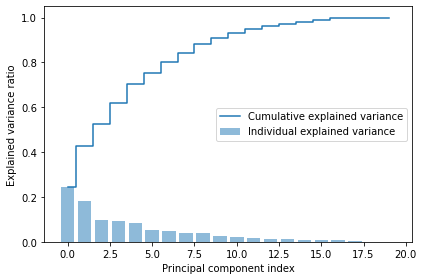

In [7]:
from sklearn.decomposition import PCA

data = Dataset(TEST_SIZE, RANDOM_STATE)
X,y = data.get_onehot_imbalanced()

pca = PCA()
X_pca = pca.fit_transform(X)

import matplotlib.pyplot as plt
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- 1st 3 principal components captures about half the explained variance. 
- If dataset was extremely high-dim, this can be applied in the pipeline to speed up training.
- But since data is noisy, we might lose some information and decrease model accuracy slightly.

## 2.2 PCA - magnitude of original features

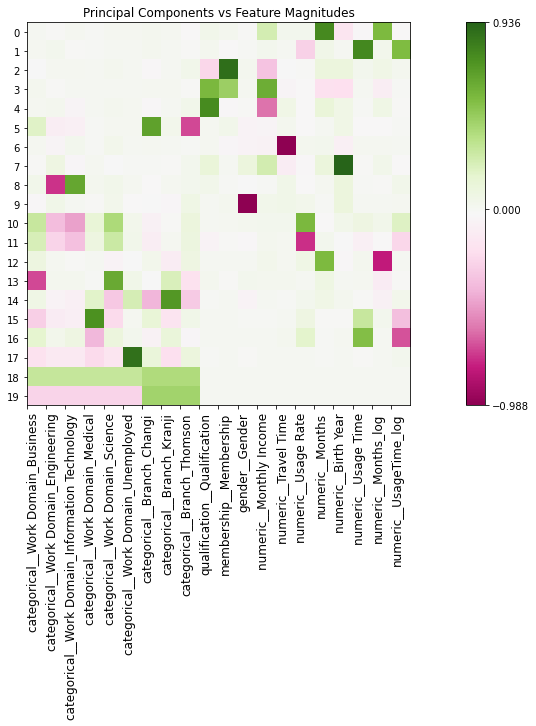

In [16]:
fig = plt.figure(figsize=(10, 14))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'PiYG')

feature_names = list(data.tfm.transformer.get_feature_names_out())

plt.gca().set_xticks(np.arange(-.5, len(feature_names)-0.5));
plt.gca().set_yticks(np.arange(0, 20));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_title('Principal Components vs Feature Magnitudes')
# plt.gca().set_yticklabels(np.arange(0,20,1), va='bottom', fontsize=12);

plt.subplots_adjust(left=None, bottom=0.5)

plt.colorbar(orientation='vertical', ticks=[pca.components_.min(), 0, pca.components_.max()], pad=0.1);
plt.show()

## 2.3 Feature_importances_ for tree based classifiers

In [32]:
def feature_importance(clf):
    try:
        # print(clf.feature_names_in_)

        feature_importances = clf['clf'].feature_importances_

        data = Dataset(TEST_SIZE,RANDOM_STATE)
        data.get_onehot_imbalanced() # needs to be fitted
        feature_name_transformed_list = data.tfm.transformer.get_feature_names_out()

        # feature_name_transformed_list = []
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[0][1]['encoder'].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[1][1].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[2][1].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[3][1].get_feature_names_out() ))

        return pd.DataFrame(feature_importances, index=feature_name_transformed_list, columns=['importance']).sort_values(['importance'], ascending=False)

    except:       
        return np.nan

feature_importance(rfc)

,importance
numeric__Monthly Income,0.2274
numeric__Usage Time,0.1607
numeric__Usage Rate,0.1297
numeric__Birth Year,0.1068
numeric__UsageTime_log,0.0950
numeric__Travel Time,0.0745
numeric__Months_log,0.0502
numeric__Months,0.0492
categorical__Work Domain_Information Technology,0.0388
membership__Membership,0.0324


## 2.4 Visualise actual vs predicted against 2 feature dims or PCA(2)
- In this case, neither very informative. 

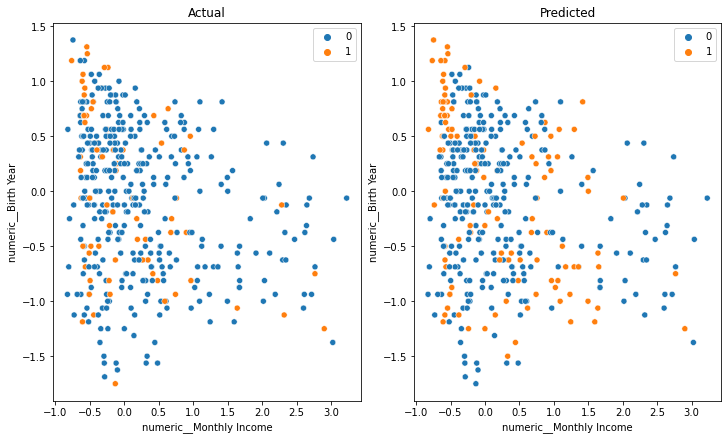

In [ ]:
import seaborn as sns
def plot_2dim(clf, X, y, dims):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6), constrained_layout=True)

    y_pred = clf.predict(X)
    sns.scatterplot(x=X[:, dims[0]], y=X[:, dims[1]], hue=y, ax=ax1, )
    sns.scatterplot(x=X[:, dims[0]], y=X[:, dims[1]], hue=y_pred, ax=ax2, )
    ax1.set_title('Actual')
    ax1.set_ylabel(data.tfm.transformer.get_feature_names_out()[dims[1]])
    ax1.set_xlabel(data.tfm.transformer.get_feature_names_out()[dims[0]])
    ax2.set_title('Predicted')
    ax2.set_ylabel(data.tfm.transformer.get_feature_names_out()[dims[1]])
    ax2.set_xlabel(data.tfm.transformer.get_feature_names_out()[dims[0]])
    

data = Dataset(TEST_SIZE, RANDOM_STATE)
X_train, X_test, y_train, y_test = data.get_transformed_onehot()

plot_2dim(rfc, X_test, y_test, (12,16))

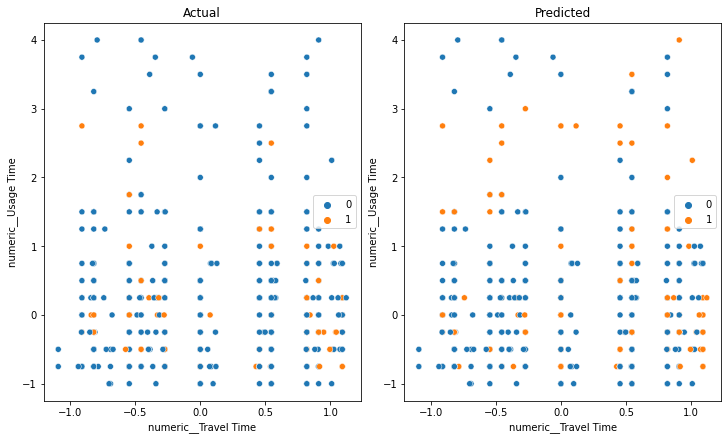

In [ ]:
plot_2dim(rfc, X_test, y_test, (13,17))

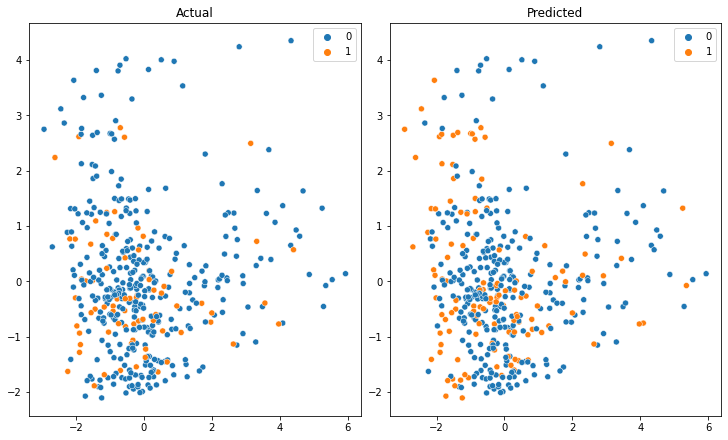

In [ ]:
def plot_pcadim(clf,pca, X, y):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6), constrained_layout=True)

    pca = PCA(2)
    # data = Dataset()
    # X,y = data.get_onehot_imbalanced()
    X_pca = pca.fit_transform(X,y)

    y_pred = clf.predict(X)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=ax1, )
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, ax=ax2, )
    ax1.set_title('Actual')
    ax2.set_title('Predicted')



data = Dataset(TEST_SIZE, RANDOM_STATE)
X_train, X_test, y_train, y_test = data.get_transformed_onehot()

plot_pcadim(rfc, pca, X_test, y_test)

## 2.4 tSNE visualisation
- attempt to see if clusters/boundaries can be found, but there doesn't seem to be distinct separators between pos/neg class.

c:\Anaconda\envs\python\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Anaconda\envs\python\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


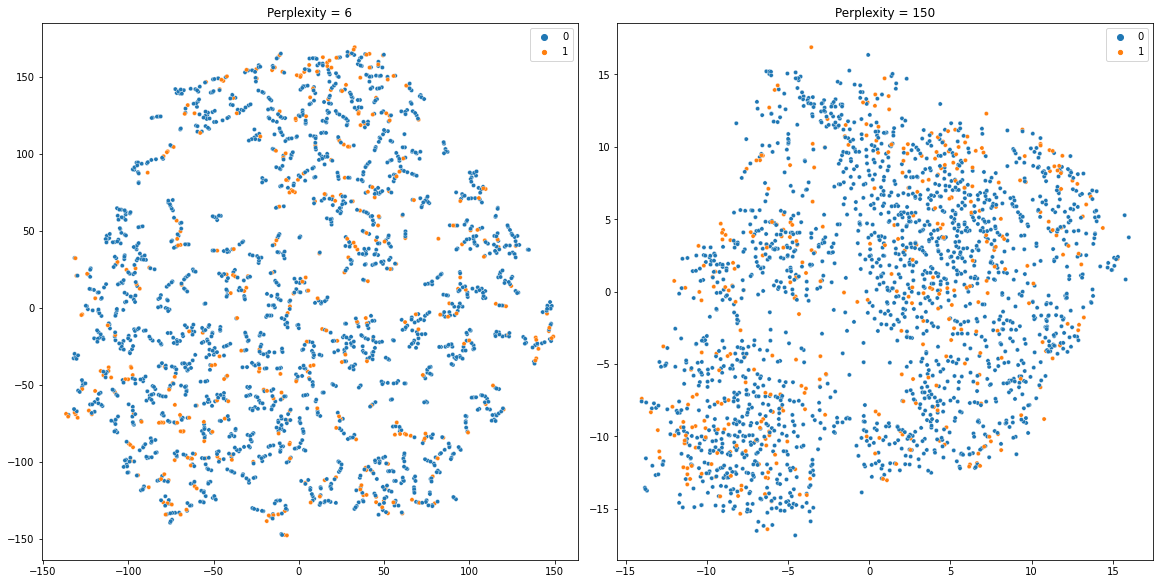

In [33]:
from sklearn.manifold import TSNE
import seaborn as sns

data = Dataset(TEST_SIZE,RANDOM_STATE)
X,y = data.get_ordinal_imbalanced()

perplexities = [6, 150]


fig, axs = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

for i, ax in zip(perplexities, axs.ravel()):
    tsne = TSNE(2, perplexity=i, n_jobs=-1, init='pca', learning_rate=1000, n_iter=5000)
    X_tsne = tsne.fit_transform(X)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, ax=ax, size=1)
    ax.set_title(f'Perplexity = {i}')




- As expected, quite noisy dataset in general. with no distinct separation of positive and negative classes. Probably won't be able to significantly improve scores by tuning further. 

-----------------